In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(rstatix)



Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘rstatix’ was built under R version 4.3.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:

color_annotation <- read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read CXCR5 expression for Confirmation Cohorts(SF4)

In [3]:
df1<-read.csv('02_NMF_CD4_T_cell_Projection/CD40_CoreB_SF4.csv')
df2<-read.csv('02_NMF_CD4_T_cell_Projection/CD40LG_CM_CD4T_SF4.csv')

df<-rbind(df1,df2)

In [11]:
write.csv(df%>% select(pbmc_sample_id,celltype,Gene,Mean_Expression,Ages),
          "/home//workspace/Source_Data/Extended_Fig8g.csv",
          row.names=FALSE)

# Plotting

In [7]:
correlation_tests <- df %>% group_by(celltype) %>% 
  dplyr::summarise(
    correlation = cor(Ages, Mean_Expression, method = 'spearman'),
    p_value = cor.test(Ages, Mean_Expression, method = 'spearman')$p.value
  )

Warning message:
“There were 2 warnings in `dplyr::summarise()`.
The first warning was:
ℹ In argument: `p_value = cor.test(Ages, Mean_Expression, method =
  "spearman")$p.value`.
ℹ In group 1: `celltype = "CM CD4 T cell"`.
Caused by warning in `cor.test.default()`:
! Cannot compute exact p-value with ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [8]:
correlation_tests

celltype,correlation,p_value
<chr>,<dbl>,<dbl>
CM CD4 T cell,-0.26662268,3.742821e-05
Core memory B cell,-0.03571568,5.875311e-01


In [9]:
df <- df %>% group_by(celltype)%>%
  arrange(desc(Ages))%>%
  mutate(label = ifelse(row_number() == 1 & 
                        Ages == max(Ages), 
                        as.character(Gene), 
                        NA_character_))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


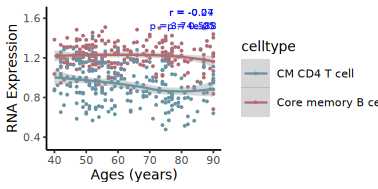

In [10]:
options(repr.plot.width = 80/25.4, repr.plot.height = 40/25.4)

p <- ggplot(df, 
            aes(Ages, Mean_Expression,color=celltype,group=celltype)) +
    geom_point(size = 0.8, stroke = 0) +
    geom_smooth(se=TRUE, linewidth=0.5,span=1) +
    theme_classic(base_size = 8)  +
    xlab('Ages (years)') + 
    ylab('RNA Expression')+theme(strip.background = element_rect(linewidth = 0))+
  geom_text(
    data = correlation_tests,
    aes(
      x = Inf, y = Inf,
      label = paste("r =", round(correlation, 2), "\np =", format.pval(p_value, digits = 3, eps = 0.0000000000000001)),
      hjust = 1.1, vjust = 1.1
    ),
    inherit.aes = FALSE,
    size = 2,
    color = "blue"
  )+
  scale_color_manual(values = color_vector)+
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.2, 0.2)))
p
ggsave('FigureC.pdf',p,width = 80/25.4,height = 40/25.4)